# Forcing and IC for single column experiments

Goal: Evaluating and separating the OM2 properties for the single column MOM6 experiments. These expariments aims at testing the convection and water mass transformation response to heat and salt fluxes
 
Context: The MOM6 [single column experiments](https://github.com/NOAA-GFDL/MOM6-examples/blob/dev/gfdl/ocean_only/single_column/KPP/data_table) require the following forcing fields:
- Net longwave radiation
- Net Shortwave radiation
- Precipitation
- **Evaporation**
- **Sensible heat flux**
- Zonal and Meridional wind stress
- Snowfall

Experiments: We will run six experiments for each mixing scheme (kpp and epbl), as represented by the image below. Heat flux experiments are meant to reproduce the conditions of NADW formationo Labrador Sea in OM2, while salt flux conditions are meant to reproduce the DSW formation on Antarctic Shelf. We will do two sets of heat flux experiments to represent regions over the labrador sea where the atmospheric temeprature are progressevely colder. Heat flux for the experiments will be the added to the heat flux experiments as Sensisble heat flux.

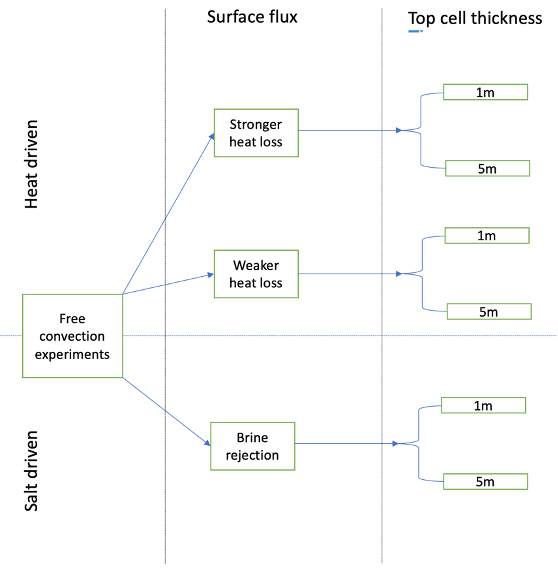


In [1]:
import cosima_cookbook as cc
import matplotlib.pyplot as plt
import cmocean as cm
import numpy as np
from dask.distributed import Client
from scipy.interpolate import interp1d

import xarray as xr
import cf_xarray as cfxr
import cartopy.crs as ccrs
import cartopy.feature as cft
import matplotlib.path as mpath
from matplotlib import gridspec
from PIL import Image
import glob

In [2]:
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:35669/status,
Dashboard: http://127.0.0.1:35669/status,Workers: 7
Total threads: 28,Total memory: 0.98 TiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:39491,Workers: 7
Dashboard: http://127.0.0.1:35669/status,Total threads: 28
Started: Just now,Total memory: 0.98 TiB
Comm: tcp://127.0.0.1:46619,Total threads: 4
Dashboard: http://127.0.0.1:34733/status,Memory: 143.87 GiB
Nanny: tcp://127.0.0.1:32909,


### **1.** Input experiments and vars

The three main experiments that will be used to obtain the data are:

In [3]:
gdata_db='/home/156/wf4500/databases/access/DSW.db'
temporary_db='/home/156/wf4500/databases/access/temporary_DSW.db'

temp_session = cc.database.create_session(temporary_db)
gdata_session = cc.database.create_session()

exp5mtop = 'ryf_5mtoponly'
exp5mtopgdata = '01deg_jra55v13_ryf9091_21mbath_5mtop'

expctrl = '01deg_jra55v13_ryf9091_21mbath'
exphalf = 'ryf_halfmtop'

I will use a variation of the code used for the SWMT to extract the full fluxes and save it:

In [4]:
(2.5e6*-7e-5) + (3992 * -1.8 * -7e-5)

-174.49700799999997

In [5]:
sfc_salt_flux_ice_test = cc.querying.getvar(expctrl, 'sfc_salt_flux_ice', gdata_session , n=1)
sfc_salt_flux_ice_test

0.3.0


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/xarray/core/dataset.py:282: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(


<xarray.DataArray 'sfc_salt_flux_ice' (time: 3, yt_ocean: 2700, xt_ocean: 3600)>
dask.array<open_dataset-sfc_salt_flux_ice, shape=(3, 2700, 3600), dtype=float32, chunksize=(1, 540, 720), chunktype=numpy.ndarray>
Coordinates:
  * xt_ocean  (xt_ocean) float64 -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean  (yt_ocean) float64 -81.11 -81.07 -81.02 ... 89.89 89.94 89.98
  * time      (time) object 1900-01-16 12:00:00 ... 1900-03-16 12:00:00
Attributes:
    long_name:      sfc_salt_flux_ice
    units:          kg/(m^2*sec)
    valid_range:    [-10000.  10000.]
    cell_methods:   time: mean
    time_avg_info:  average_T1,average_T2,average_DT
    standard_name:  downward_sea_ice_basal_salt_flux
    ncfiles:        ['/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf90...

In [6]:
#Function to extract the surface fluxes
from gsw import alpha, SA_from_SP, p_from_z, CT_from_pt, beta, sigma0
def save_SWMT_forcing_SH(expt, session, start_time, end_time, lat_north = -59, n = None):
    '''
    This is a variation of the original cosima cookbook SWMT calculations, that is used to save soley the surface heat and salt fluxes that drive SWMT
    '''
    ## getvar all required variables
    SST = cc.querying.getvar(expt, 'temp', session, frequency='1 monthly').isel(st_ocean=0) - 273.15 # SST - conservative temperature in K (sheck this is the case for your run)
    SSS_PSU = cc.querying.getvar(expt, 'salt', session, frequency='1 monthly').isel(st_ocean=0)      # SSS - practical salinity (not absolute)
    pme_river = cc.querying.getvar(expt, 'pme_river', session, frequency='1 monthly')       # mass flux of precip - evap + river
    # Note that is sfc_salt_flux_ice is not saved, you can use sfc_salt_flux_ice = 0.005 * melt instead
    sfc_salt_flux_ice = cc.querying.getvar(expt, 'sfc_salt_flux_ice', session, frequency='1 monthly')         # mass flux of salt from ice formation/melt
    sfc_salt_flux_restore = cc.querying.getvar(expt, 'sfc_salt_flux_restore', session, frequency='1 monthly') # mass flux of salt from surface salinity restoring

    ## getvar the components of the net surface heat fux instead of the net_surface_heating variable
    sfc_hflux_from_runoff = cc.querying.getvar(expt, 'sfc_hflux_from_runoff', session, frequency='1 monthly') # W/m²
    sfc_hflux_coupler = cc.querying.getvar(expt, 'sfc_hflux_coupler', session, frequency='1 monthly')         # W/m²
    sfc_hflux_pme = cc.querying.getvar(expt, 'sfc_hflux_pme', session, frequency='1 monthly')                 # W/m²
    frazil_3d_int_z = cc.querying.getvar(expt, 'frazil_3d_int_z', session, frequency='1 monthly')             # W/m²
    geolon_t = cc.querying.getvar(expt, 'geolon_t', session, n=1)
    geolat_t = cc.querying.getvar(expt, 'geolat_t', session, n=1)
    
    ## slice for time and latitudinal constraints
    time_slice = slice(start_time, end_time)
    lat_slice = slice(-90, lat_north)
    SST = SST.sel(time=time_slice, yt_ocean=lat_slice)
    SSS_PSU = SSS_PSU.sel(time=time_slice, yt_ocean=lat_slice)
    pme_river = pme_river.sel(time=time_slice, yt_ocean=lat_slice)
    sfc_salt_flux_ice = sfc_salt_flux_ice.sel(time=time_slice, yt_ocean=lat_slice)
    sfc_salt_flux_restore = sfc_salt_flux_restore.sel(time=time_slice, yt_ocean=lat_slice)
    sfc_hflux_from_runoff = sfc_hflux_from_runoff.sel(time=time_slice, yt_ocean=lat_slice)
    sfc_hflux_coupler = sfc_hflux_coupler.sel(time=time_slice, yt_ocean=lat_slice)
    sfc_hflux_pme = sfc_hflux_pme.sel(time=time_slice, yt_ocean=lat_slice)
    frazil_3d_int_z = frazil_3d_int_z.sel(time=time_slice, yt_ocean=lat_slice)
    
    lon_t = geolon_t.sel(yt_ocean=lat_slice)
    lat_t = geolat_t.sel(yt_ocean=lat_slice)
    
    ## extract coordinate arrays
    yt_ocean = SST.yt_ocean.values
    xt_ocean = SST.xt_ocean.values
    st_ocean = cc.querying.getvar(expt,'st_ocean',session,n=1).load()
    time_monthly = SST.time.values
    
    ## construct an xarray of days per month (check this is relevant to your run), simple modification if non integer number of years analysed
    start_month = int(start_time[5:7])
    end_month = int(end_time[5:7])
    n_years = int(len(SST.time)/12)
    months_standard_noleap = np.array([31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31])
    if start_month != 1:
        months_offset_noleap = np.append(months_standard_noleap[(start_month-1):],months_standard_noleap[:(start_month-1)])
    else:
        months_offset_noleap = months_standard_noleap
    #months_offset_noleap = months_standard_noleap[(start_month-1):(end_month-1)]
    #print(months_offset_noleap)
    days_per_month = xr.DataArray(np.tile(months_offset_noleap, n_years), coords = [time_monthly], dims = ['time'], name = 'days per month')

    ## compute net surface heat flux from its component terms
    net_surface_heating = sfc_hflux_from_runoff+ sfc_hflux_coupler+ sfc_hflux_pme+ frazil_3d_int_z # W/m2
    
    ## now I use some TEOS-10 gsw functions to compute absolute salinity, then potential density fields
    ## these are numpy functions, if you have memory errors this is a good step to check (though I have found
    ## this works on the VDI for 0.1 degree data, might be issues for very long time periods)
    depth = -st_ocean[0].values # st_ocean value of the uppermost cell
    depth_tile = (lat_t*0 + 1) * depth
    pressure = xr.DataArray(p_from_z(depth_tile, lat_t), coords = [yt_ocean, xt_ocean], dims = ['yt_ocean', 'xt_ocean'], name = 'pressure', attrs = {'units':'dbar'})
    
    # convert units to absolute salinity 
    SSS = xr.DataArray(SA_from_SP(SSS_PSU, pressure, lon_t, lat_t), coords = [time_monthly, yt_ocean, xt_ocean], dims = ['time','yt_ocean', 'xt_ocean'], name = 'sea surface salinity', attrs = {'units':'Absolute Salinity (g/kg)'})
    
    ## SST is already saved as conservative temperature in this run, if you are working with an older run with potential 
    ## temperature saved, conversion will be required (make sure you work with C not K)
    # SST = xr.DataArray(CT_from_pt(SSS_AS,SST_PT), coords = [time_monthly, yt_ocean, xt_ocean], dims = ['time', 'yt_ocean', 'xt_ocean'], name = 'sea surface temperature', attrs = {'units':'Conservative Temperature (C)'})
    # compute potential density referenced to 1000dbar (or referenced otherwise, depending on your purpose)
    pot_rho_1 = xr.DataArray(sigma0(SSS, SST), coords = [time_monthly, yt_ocean, xt_ocean], dims = ['time', 'yt_ocean', 'xt_ocean'], name = 'potential density ref 1000dbar', attrs = {'units':'kg/m^3 (-1000 kg/m^3)'})
    pot_rho_1 = pot_rho_1.load()
    
    # Compute salt transformation (no density binning)
    haline_contraction = xr.DataArray(beta(SSS, SST, pressure), coords = [time_monthly, yt_ocean, xt_ocean], dims = ['time','yt_ocean', 'xt_ocean'], name = 'saline contraction coefficient (constant conservative temp)', attrs = {'units':'kg/g'})
    
    # Note that the salt fluxes have units of (kg of salt)/m²/s, while β has
    # units of kg / (g of salt), so we need to multiply the salt fluxes by 1000,
    # the fresh water flux `pme_river` has units of (kg of water)/(m²/s) and needs
    # to be multiplied by SSS to convert to (g of salt)/m²/s
    # This gives units of (kg of water)/m² for the salt_transformation but it
    # will later be divided by time and density and be in m/s:
    salt_transformation = haline_contraction * (SSS * pme_river - (sfc_salt_flux_ice + sfc_salt_flux_restore)*1000) * days_per_month #! before was PSU, why?
    sfc_salt_flux_ice_water=-((sfc_salt_flux_ice/(SSS/1000)) -  sfc_salt_flux_ice)  #sfc_salt_flux_ice in (kg of freshwater)/(m²/s), + freshwater leaves the ocean
    sfc_salt_flux_restore_water = -((sfc_salt_flux_restore/(SSS/1000)) - sfc_salt_flux_restore) # sfc_salt_flux_restore_water in (kg of freshwater)/(m²/s), + freshwater leaves the ocean
    freshwater_fluxes=pme_river + sfc_salt_flux_ice_water + sfc_salt_flux_restore_water

    salt_transformation = salt_transformation.load()


    # Compute heat transformation (no density binning)
    thermal_expansion = xr.DataArray(alpha(SSS, SST, pressure), coords = [time_monthly, yt_ocean, xt_ocean], dims = ['time','yt_ocean', 'xt_ocean'], name = 'thermal expansion coefficient (constant conservative temp)', attrs = {'units':'1/K'})
    heat_transformation = thermal_expansion * net_surface_heating * days_per_month
    heat_transformation = heat_transformation.load()
    
    net_surface_heating.name='net_surface_heating'
    salt_transformation.name='salt_transformation'
    sfc_salt_flux_ice_water.name='sfc_salt_flux_ice_water'
    sfc_salt_flux_restore_water.name='sfc_salt_flux_restore_water'
    heat_transformation.name='heat_transformation'
    freshwater_fluxes.name='salt_flux_into_freshwater_flux'
    data_out = xr.merge([freshwater_fluxes,-heat_transformation,net_surface_heating, sfc_hflux_from_runoff, sfc_hflux_coupler, sfc_hflux_pme, frazil_3d_int_z, thermal_expansion, -salt_transformation, haline_contraction,  pme_river, sfc_salt_flux_ice_water, sfc_salt_flux_restore_water])
    return data_out

In [7]:
#shelf mask definition
def shelf_mask_isobath(var):
    '''
    Masks ACCESS-OM2-01 variables by the region polewards of the 1000m isobath as computed using 
    a script contributed by Adele Morrison.
    Only to be used with ACCESS-OM2-0.1 output!
    '''
    contour_file = np.load('/g/data/ik11/grids/Antarctic_slope_contour_1000m.npz')
    
    shelf_mask = contour_file['contour_masked_above']
    yt_ocean = contour_file['yt_ocean']
    xt_ocean = contour_file['xt_ocean']
    
    # in this file the points along the isobath are given a positive value, the points outside (northwards) 
    # of the isobath are given a value of -100 and all the points on the continental shelf have a value of 0 
    # so we mask for the 0 values 
    shelf_mask[np.where(shelf_mask!=0)] = np.nan
    shelf_mask = shelf_mask+1
    shelf_map  = np.nan_to_num(shelf_mask)
    shelf_mask = xr.DataArray(shelf_mask, coords = [('yt_ocean', yt_ocean), ('xt_ocean', xt_ocean)])
    shelf_map  = xr.DataArray(shelf_map,  coords = [('yt_ocean', yt_ocean), ('xt_ocean', xt_ocean)])
    
    # then we want to multiply the variable with the mask so we need to account for the shape of the mask. 
    # The mask uses a northern cutoff of 59S.
    masked_var = var.sel(yt_ocean = slice(-90, -59.03)) * shelf_mask

    return masked_var, shelf_map

In [8]:
#land mask
ht = cc.querying.getvar(expctrl, 'ht', gdata_session, n=1) 
ht = ht.sel(yt_ocean = slice(-90, -59))

land_mask = (ht*0).fillna(1)

0.3.0


### **2.** Southern Hemisphere DSW

In [47]:
start_time="1909-01"
end_time="1909-12"
#getting control fluxes
ctrl_fluxes = save_SWMT_forcing_SH(expctrl, gdata_session, start_time, end_time, lat_north = -59, n = None)
#getting 5mtop fluxes
r5mtop_fluxes = save_SWMT_forcing_SH(exp5mtop, temp_session, start_time, end_time, lat_north = -59, n = None)
#getting halfmmtop fluxes
halfmtop_fluxes = save_SWMT_forcing_SH(exphalf, temp_session, start_time, end_time, lat_north = -59, n = None)

/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/xarray/core/dataset.py:282: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/xarray/core/dataset.py:282: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/xarray/core/dataset.py:282: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3

In [49]:
ctrl_fluxesY=ctrl_fluxes.copy()
r5mtop_fluxesY = r5mtop_fluxes.copy()
halfmtop_fluxesY = halfmtop_fluxes.copy()

We only want winter fluxes, so lets slice the flux from may to September

In [50]:
winter_slice=slice("1909-05","1909-09")

ctrl_fluxes = ctrl_fluxes.sel(time=winter_slice).mean('time').compute()
r5mtop_fluxes = r5mtop_fluxes.sel(time=winter_slice).mean('time').compute()
halfmtop_fluxes = halfmtop_fluxes.sel(time=winter_slice).mean('time').compute()

Masking offshelf regions

In [51]:
#mean fluxes
ctrl_fluxesM, shelf_map = shelf_mask_isobath(ctrl_fluxes)
r5mtop_fluxesM, shelf_map = shelf_mask_isobath(r5mtop_fluxes)
halfmtop_fluxesM, shelf_map = shelf_mask_isobath(halfmtop_fluxes)

In [53]:
#Monthly data for 1 year
ctrl_fluxesY, shelf_map = shelf_mask_isobath(ctrl_fluxesY); ctrl_fluxesY=ctrl_fluxesY.compute()
r5mtop_fluxesY, shelf_map = shelf_mask_isobath(r5mtop_fluxesY); r5mtop_fluxesY=r5mtop_fluxesY.compute()
halfmtop_fluxesY, shelf_map = shelf_mask_isobath(halfmtop_fluxesY); halfmtop_fluxesY=halfmtop_fluxesY.compute()

**Direction of fluxes:**

- Positve fluxes (+) means waters get denser (in $m s^{-1}$) for: Salt transformation and heat transformation.
- Positive (+) means waters gain heat  (in $W m^{-2}$) for: net_surface_heating, sfc_hflux_from_runoff, sfc_hflux_coupler, sfc_hflux_pme, frazil_3d_int_z. 
- Positive (+) means surface gains water  (in $kg_{w}\ m^{-2} s^{-1}$) for: freshwater_fluxes,pme_river, sfc_salt_flux_ice_water,  sfc_salt_flux_restore_water

**Location of fluxes:**
- Comparying the SWMT curves for year 1909 for allp OM2 simulations, we see that a lot of the signal in change in SWMT with forcing comes from Weddell and Ross Sea, with the Weddell signal being very coherent between the 3 vertical resolution experiments. So  let's separate the fluxes for Weddell and Ross, and discuss in the meeting which one would be the best for our single column experiment
![alt text](/home/156/wf4500/v45_wf4500/DSW_collaborative/sigma0_SWMT/figs/SWMTsimulations_comp_by_sector_sigma0_total.png "SWMT comparisson by sector. We are aprticularly interested in the Weddell and Ross seas transformations below the density treshold of the DSW")


Below are the regions we will select for analyzing the surface forcing:

In [12]:
#Weddell Mask
Wlatmax=-72; Wlonwest=-62; Wloneast=-30
shelf_map_Weddell=(shelf_map.where(shelf_map.yt_ocean<Wlatmax).where(shelf_map.xt_ocean>Wlonwest).where(shelf_map.xt_ocean<Wloneast) * shelf_map.where(shelf_map>0) * land_mask.where(land_mask<=0)) +1
#Ross mask
Rlatmax=-73; Rlonwest=-200; Rloneast=-165
shelf_map_Ross=(shelf_map.where(shelf_map.yt_ocean<Rlatmax).where(shelf_map.xt_ocean>Rlonwest).where(shelf_map.xt_ocean<Rloneast) * shelf_map.where(shelf_map>0) * land_mask.where(land_mask<=0)) +1

(-0.5, 2399.5, 2679.5, -0.5)

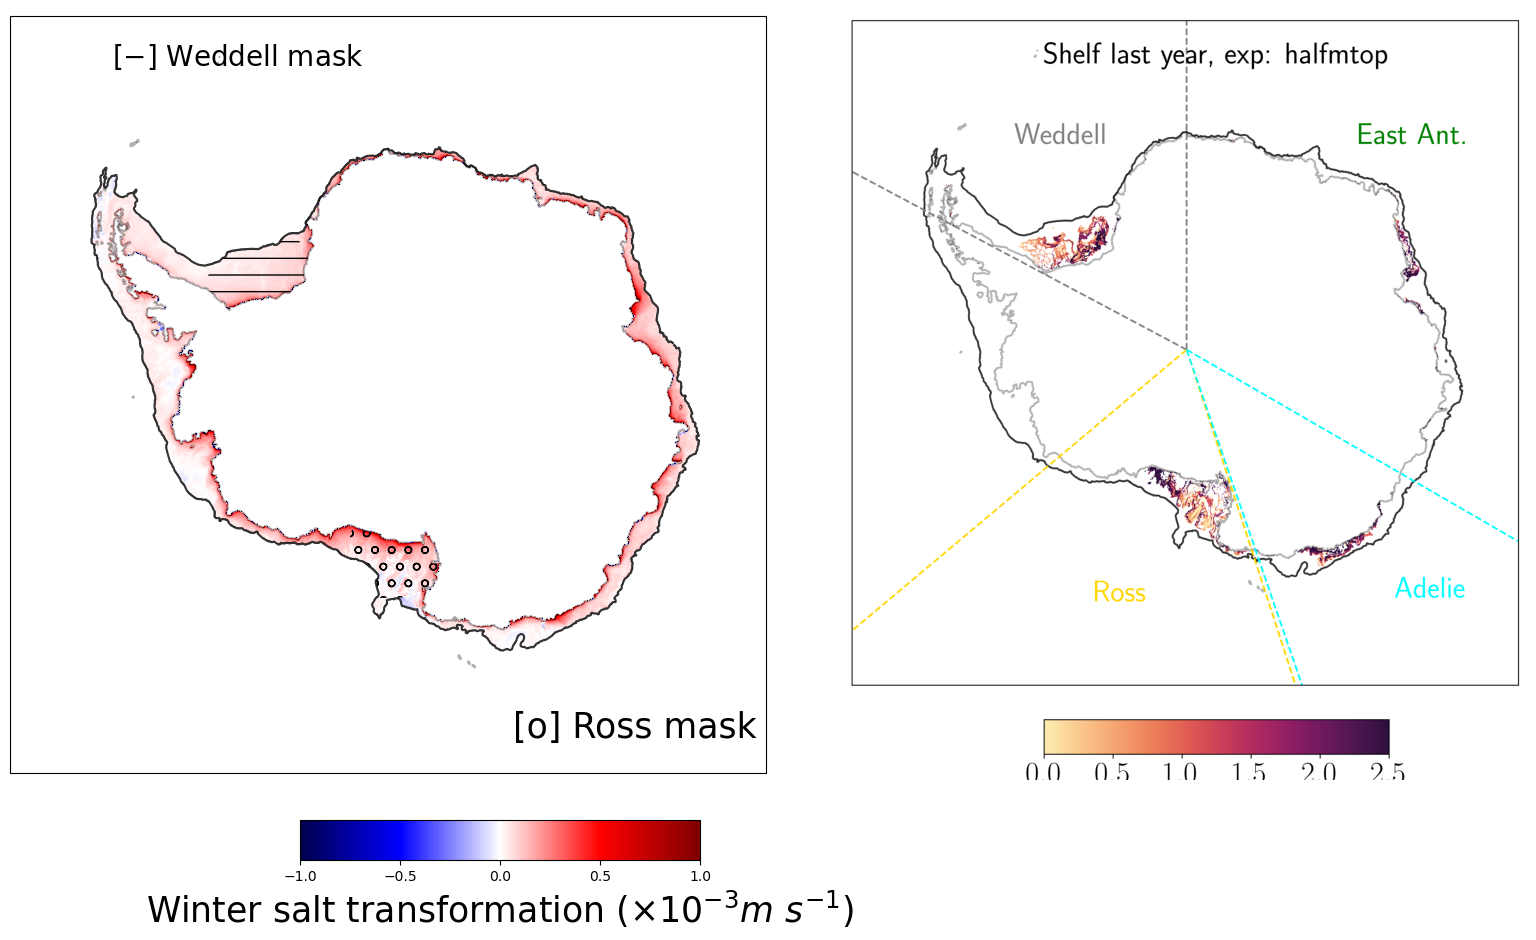

In [13]:
land_50m = cft.NaturalEarthFeature('physical', 'land', '50m',
                                   edgecolor='black', facecolor='papayawhip', linewidth=0.5)
from matplotlib import gridspec
fig  = plt.figure(1, figsize = (20, 10))
gs = gridspec.GridSpec(1,2, width_ratios = [2, 2]) 
gs.update(wspace = 0.05)

ax, ax1 = plt.subplot(gs[0], projection=ccrs.SouthPolarStereo()),  plt.subplot(gs[1])


ax.contour(shelf_map.xt_ocean, shelf_map.yt_ocean, shelf_map, [0, 1],
           colors='k', alpha =0.8, transform = ccrs.PlateCarree())
im0 = ax.pcolormesh(ctrl_fluxesM.xt_ocean, ctrl_fluxesM.yt_ocean,ctrl_fluxesM.salt_transformation*1e3,
         transform=ccrs.PlateCarree(),
         vmin=-1, vmax=1,
         cmap='seismic')
cax = fig.add_axes([0.27, 0.03, 0.2, 0.04])
cbar0= plt.colorbar(im0, cax=cax, orientation='horizontal', shrink = 0.5, ticks = [-1,-.5,0,.5,1])
cbar0.set_label(r'Winter salt transformation ($\times 10^{-3}m\ s^{-1}$)', fontsize = 25)
ax.contour(ctrl_fluxesM.xt_ocean, ctrl_fluxesM.yt_ocean,land_mask, [0, 1],
           colors='k', alpha = 0.3, transform = ccrs.PlateCarree() )


#Weddell Region
ax.contourf(shelf_map_Weddell.xt_ocean,shelf_map_Weddell.yt_ocean,shelf_map_Weddell,colors='black',hatches='-', alpha=0.0,label='Weddell Forcing', transform = ccrs.PlateCarree())
#Weddell Region
ax.contourf(shelf_map_Ross.xt_ocean,shelf_map_Ross.yt_ocean,shelf_map_Ross,colors='black',hatches='o', alpha=0.0,label='Ross Forcing', transform = ccrs.PlateCarree())
ax.text(-40,-55,r"[$-$] Weddell mask",color='black',fontsize=20,transform = ccrs.PlateCarree())
ax.text(-200,-60,r"[o] Ross mask",color='black',fontsize=25,transform = ccrs.PlateCarree())
#importing SWMT image for 21mbath
img = np.asarray(Image.open('/home/156/wf4500/v45_wf4500/DSW_collaborative/sigma0_SWMT/figs/SWMTshelfmaps_halfmtop_sigma0_total.png'))
ax1.imshow(img[320:,900:3300,:]); ax1.set_xticks([]); ax1.set_yticks([]);ax1.axis('off')

Now that we have set up the mask, lets import the T and S properties of the model. I will use the summer january conditions for the Initial conditions, to simulate a transition from summer to winter.

In [14]:
#surface area for averaging
Tarea= cc.querying.getvar(expctrl, 'area_t', gdata_session, n=1)

#Mean T and S profiles for Weddell
Wlonslice=slice(Wlonwest,Wloneast)
Wtemp= (( cc.querying.getvar(expctrl, 'temp', gdata_session, start_time=start_time,end_time=end_time,\
                             chunks={'st_ocean':'10gb'}).sel(time=start_time) - 273.15 )\
                                * shelf_map_Weddell).weighted(Tarea.fillna(0)).mean(['xt_ocean','yt_ocean'])
Wtempmax= (( cc.querying.getvar(expctrl, 'temp', gdata_session, start_time=start_time,end_time=end_time,\
                             chunks={'st_ocean':'10gb'}).sel(time=start_time) - 273.15 )\
                                * shelf_map_Weddell).max(['xt_ocean','yt_ocean'])

Wtempoffshore= (( cc.querying.getvar(expctrl, 'temp', gdata_session, start_time=start_time,end_time=end_time,\
                             chunks={'st_ocean':'10gb'}).sel(time=start_time) - 273.15 )\
                                * shelf_map_Weddell)
Wtempoffshore=Wtempoffshore.where(Wtempoffshore.xt_ocean>-75).where(Wtempoffshore.xt_ocean>-50).weighted(Tarea.fillna(0)).mean(['xt_ocean','yt_ocean'])

Wsalt= (cc.querying.getvar(expctrl, 'salt', gdata_session, start_time=start_time,end_time=end_time,\
                             chunks={'st_ocean':'10gb'}).sel(time=start_time) \
                              * shelf_map_Weddell).weighted(Tarea.fillna(0)).mean(['xt_ocean','yt_ocean'])
Wsaltmin= (cc.querying.getvar(expctrl, 'salt', gdata_session, start_time=start_time,end_time=end_time,\
                             chunks={'st_ocean':'10gb'}).sel(time=start_time) \
                              * shelf_map_Weddell).min(['xt_ocean','yt_ocean'])

Wsaltoffshore= (( cc.querying.getvar(expctrl, 'salt', gdata_session, start_time=start_time,end_time=end_time,\
                             chunks={'st_ocean':'10gb'}).sel(time=start_time) )\
                                * shelf_map_Weddell)
Wsaltoffshore=Wsaltoffshore.where(Wsaltoffshore.xt_ocean>-75).where(Wsaltoffshore.xt_ocean>-50).weighted(Tarea.fillna(0)).mean(['xt_ocean','yt_ocean'])


#Mean Taux and Tauy and Wind stress
W_ucoords= cc.querying.getvar(expctrl, 'tau_x', gdata_session, n=1) #getting 1 instance of taux for grid interpolation

WTaux= (cc.querying.getvar(expctrl, 'tau_x', gdata_session, start_time=start_time,end_time=end_time,\
                             chunks={'xu_ocean':'30gb','yu_ocean':'30gb'}).sel(time=winter_slice).mean('time') \
                              * shelf_map_Weddell.interp(xt_ocean=W_ucoords.xu_ocean,\
                                                         yt_ocean=W_ucoords.yu_ocean)).sel(xu_ocean=Wlonslice).sel(yu_ocean=slice(-80,Wlatmax))
WTauxmean=WTaux.weighted(Tarea.interp(xt_ocean=W_ucoords.xu_ocean,yt_ocean=W_ucoords.yu_ocean).fillna(0)).mean(['xu_ocean','yu_ocean'])
WTaux.name='Zonal wind stress [N/m²]'
WTauy= (cc.querying.getvar(expctrl, 'tau_y', gdata_session, start_time=start_time,end_time=end_time,\
                             chunks={'xu_ocean':'30gb','yu_ocean':'30gb'}).sel(time=winter_slice).mean('time') \
                              * shelf_map_Weddell.interp(xt_ocean=W_ucoords.xu_ocean,\
                                                         yt_ocean=W_ucoords.yu_ocean)).sel(xu_ocean=Wlonslice).sel(yu_ocean=slice(-80,Wlatmax))
WTauy.name='Meridional wind stress [N/m²]'
WTauymean=WTauy.weighted(Tarea.interp(xt_ocean=W_ucoords.xu_ocean,yt_ocean=W_ucoords.yu_ocean).fillna(0)).mean(['xu_ocean','yu_ocean'])

Wmeanstress= ((WTaux**2) + (WTauy**2))**0.5

/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/xarray/core/dataset.py:282: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(


Surface forcing fields and averages on Weddell

In [95]:
#FWF for timeseries


#ctrl
cW_netFWY = (ctrl_fluxesY.salt_flux_into_freshwater_flux * shelf_map_Weddell) #Kg Fw/m2/s
cW_netFWY.name="Salt flux into FW Flux [Kg of fw/m²/s]"
cW_netFWmeanY = cW_netFWY.weighted(Tarea.fillna(0)).mean(['xt_ocean','yt_ocean']).values
cW_netFWminY = cW_netFWY.min(['xt_ocean','yt_ocean']).values

#5mtoponly
r5W_netFWY = (r5mtop_fluxesY.salt_flux_into_freshwater_flux * shelf_map_Weddell) #Kg Fw/m2/s
r5W_netFWY.name="Salt flux into FW Flux [Kg of fw/m²/s]"
r5W_netFWmeanY = r5W_netFWY.weighted(Tarea.fillna(0)).mean(['xt_ocean','yt_ocean']).values
r5W_netFWminY = r5W_netFWY.min(['xt_ocean','yt_ocean']).values

#halfmtop
hW_netFWY = (halfmtop_fluxesY.salt_flux_into_freshwater_flux * shelf_map_Weddell) #Kg Fw/m2/s
hW_netFWY.name="Salt flux into FW Flux [Kg of fw/m²/s]"
hW_netFWmeanY = hW_netFWY.weighted(Tarea.fillna(0)).mean(['xt_ocean','yt_ocean']).values
hW_netFWminY = hW_netFWY.min(['xt_ocean','yt_ocean']).values

In [70]:
############net surface heating
#ctrl
cW_netheating = (ctrl_fluxesM.net_surface_heating * shelf_map_Weddell) #W/m2
cW_netheating.name="Surface Heat Fluxes [W/m²]"
cW_netheatingmean = cW_netheating.weighted(Tarea.fillna(0)).mean(['xt_ocean','yt_ocean']).values
cW_netheatingmin = cW_netheating.min(['xt_ocean','yt_ocean']).values

#r5mtop
r5W_netheating = (r5mtop_fluxesM.net_surface_heating * shelf_map_Weddell) #W/m2
r5W_netheating.name="Surface Heat Fluxes [W/m²]"
r5W_netheatingmean = r5W_netheating.weighted(Tarea.fillna(0)).mean(['xt_ocean','yt_ocean']).values

#halfmtop
hW_netheating = (halfmtop_fluxesM.net_surface_heating * shelf_map_Weddell) #W/m2
hW_netheating.name="Surface Heat Fluxes [W/m²]"
hW_netheatingmean = hW_netheating.weighted(Tarea.fillna(0)).mean(['xt_ocean','yt_ocean']).values

############net surface heating minus  pme
#ctrl
cW_netheatingpme = ((ctrl_fluxesM.net_surface_heating -ctrl_fluxesM.sfc_hflux_pme)* shelf_map_Weddell) #W/m2
cW_netheatingpme.name="Surface Heat Fluxes - pme [W/m²]"
cW_netheatingmeanpme = cW_netheatingpme.weighted(Tarea.fillna(0)).mean(['xt_ocean','yt_ocean']).values
#r5mtop
r5W_netheatingpme = ((r5mtop_fluxesM.net_surface_heating - r5mtop_fluxesM.sfc_hflux_pme)* shelf_map_Weddell) #W/m2
r5W_netheatingpme.name="Surface Heat Fluxes - pme [W/m²]"
r5W_netheatingmeanpme = r5W_netheating.weighted(Tarea.fillna(0)).mean(['xt_ocean','yt_ocean']).values

#halfmtop
hW_netheatingpme = ((halfmtop_fluxesM.net_surface_heating - halfmtop_fluxesM.sfc_hflux_pme)* shelf_map_Weddell) #W/m2
hW_netheatingpme.name="Surface Heat Fluxes - pme [W/m²]"
hW_netheatingmeanpme = hW_netheating.weighted(Tarea.fillna(0)).mean(['xt_ocean','yt_ocean']).values



############net surface heating
#ctrl
cW_netFW = (ctrl_fluxesM.salt_flux_into_freshwater_flux * shelf_map_Weddell) #Kg Fw/m2/s
cW_netFW.name="Salt flux into FW Flux [Kg of fw/m²/s]"
cW_netFWmean = cW_netFW.weighted(Tarea.fillna(0)).mean(['xt_ocean','yt_ocean']).values

#5mtoponly
r5W_netFW = (r5mtop_fluxesM.salt_flux_into_freshwater_flux * shelf_map_Weddell) #Kg Fw/m2/s
r5W_netFW.name="Salt flux into FW Flux [Kg of fw/m²/s]"
r5W_netFWmean = r5W_netFW.weighted(Tarea.fillna(0)).mean(['xt_ocean','yt_ocean']).values

#halfmtop
hW_netFW = (halfmtop_fluxesM.salt_flux_into_freshwater_flux * shelf_map_Weddell) #Kg Fw/m2/s
hW_netFW.name="Salt flux into FW Flux [Kg of fw/m²/s]"
hW_netFWmean = hW_netFW.weighted(Tarea.fillna(0)).mean(['xt_ocean','yt_ocean']).values


In [16]:
cW_netheatingmin

array(-60.528015, dtype=float32)

In [17]:
cW_netFWmean

array(-7.11441189e-05)

In [18]:
figdir = '/home/156/wf4500/v45_wf4500/DSW_collaborative/sigma0_SWMT/figs/'

Below is some reference value for comparisson with free convection experiments previously run in GFDL

In [19]:
#Van roekel experiment uses 1.3 mm of fw/day
VR= 1.37 ##mm/day or kg/m2/day
# and below in 10^-2 g/ m2 /s 
VR2=( VR*1e3/(60*60*24) )*1e2 
VR2

1.5856481481481481

What is the maximum FWF found in all simulations?

In [102]:
(r5W_netFWY-cW_netFWY).max().values

array(0.00045527)

Text(0.5, 0, 'Month')

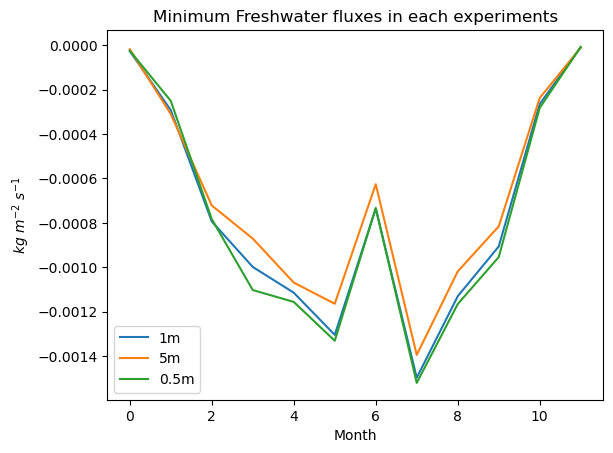

In [96]:

plt.plot(cW_netFWminY,label='1m')
plt.plot(r5W_netFWminY,label='5m')
plt.plot(hW_netFWminY,label='0.5m')
plt.title("Minimum Freshwater fluxes in each experiments")
plt.legend()
plt.ylabel(r"$kg\ m^{-2}\ s^{-1}$")
plt.xlabel('Month')

This plot show us a few things... first, we can increase the FWF experiments a little more, to $1.5\ \times 10^{-3}\ kg\ m^{-2}\ s^{-1}$... an between different vertical resolutions (1m and 5m), the FWF can vary to up to $4.5\ \times 10^{-4}\ kg\ m^{-2}\ s^{-1}$, which can cause a subestimation of the surface density signal in the single column case (Which according to a regression curve suggest a $0.003\ kg\ m^{-3}$ subestimation)

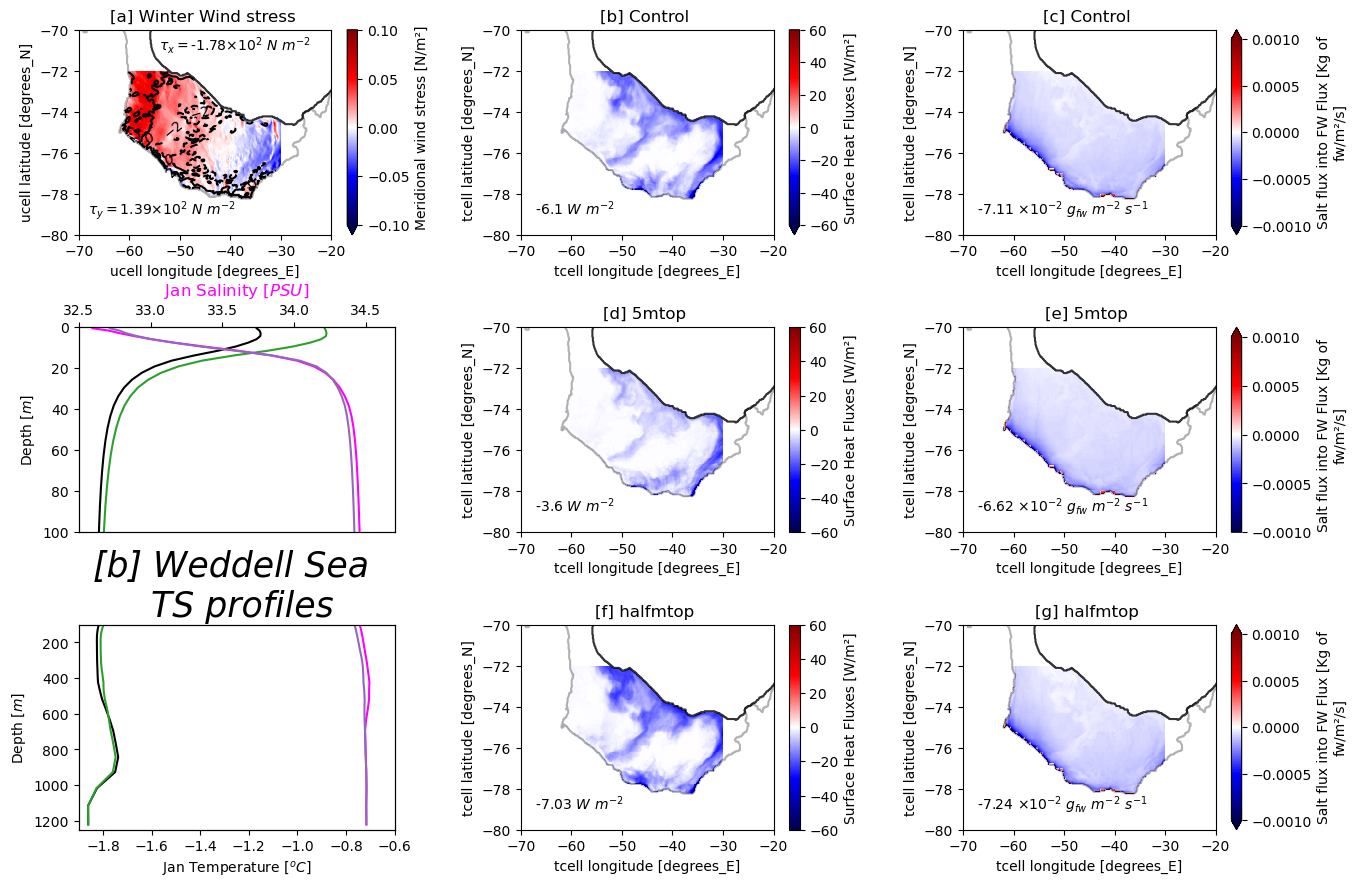

In [20]:
fig  = plt.figure(figsize = (15, 10))
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.45)


######## Heat Fluxes
ax2 = fig.add_subplot(332)
cW_netheating.plot(vmin=-60,vmax=60,cmap='seismic')
ax2.contour(shelf_map.xt_ocean, shelf_map.yt_ocean, shelf_map, [0, 1],
           colors='k', alpha =0.8)
ax2.contour(ctrl_fluxesM.xt_ocean, ctrl_fluxesM.yt_ocean,land_mask, [0, 1],
           colors='k', alpha = 0.3 )
ax2.text(-68,-79,r" " + str(np.round(cW_netheatingmean,2)) + " $W\ m^{-2}$")
ax2.set_xlim(-70,-20); ax2.set_ylim(-80,-70); ax2.set_title(r"[b] Control ")


ax5 = fig.add_subplot(335)
r5W_netheating.plot(vmin=-60,vmax=60,cmap='seismic')
ax5.contour(shelf_map.xt_ocean, shelf_map.yt_ocean, shelf_map, [0, 1],
           colors='k', alpha =0.8)
ax5.contour(r5mtop_fluxesM.xt_ocean, r5mtop_fluxesM.yt_ocean,land_mask, [0, 1],
           colors='k', alpha = 0.3 )
ax5.text(-68,-79,r" " + str(np.round(r5W_netheatingmean,2)) + " $W\ m^{-2}$")
ax5.set_xlim(-70,-20); ax5.set_ylim(-80,-70); ax5.set_title(r"[d] 5mtop ")

ax8 = fig.add_subplot(338)
hW_netheating.plot(vmin=-60,vmax=60,cmap='seismic')
ax8.contour(shelf_map.xt_ocean, shelf_map.yt_ocean, shelf_map, [0, 1],
           colors='k', alpha =0.8)
ax8.contour(halfmtop_fluxesM.xt_ocean, halfmtop_fluxesM.yt_ocean,land_mask, [0, 1],
           colors='k', alpha = 0.3 )
ax8.text(-68,-79,r" " + str(np.round(hW_netheatingmean,2)) + " $W\ m^{-2}$")
ax8.set_xlim(-70,-20); ax8.set_ylim(-80,-70); ax8.set_title(r"[f] halfmtop ")

###### Salt fluxes
ax3 = fig.add_subplot(333)
cW_netFW.plot(vmin=-.001,vmax=.001,cmap='seismic')
ax3.contour(shelf_map.xt_ocean, shelf_map.yt_ocean, shelf_map, [0, 1],
           colors='k', alpha =0.8)
ax3.contour(ctrl_fluxesM.xt_ocean, ctrl_fluxesM.yt_ocean,land_mask, [0, 1],
           colors='k', alpha = 0.3 )
ax3.text(-68,-79,r" " + str(np.round(cW_netFWmean*1e3*1e2,2)) + r" $\times 10^{-2}\ g_{fw}\ m^{-2}\ s^{-1}$")
ax3.set_xlim(-70,-20); ax3.set_ylim(-80,-70); ax3.set_title(r"[c] Control ")


ax6 = fig.add_subplot(336)
r5W_netFW.plot(vmin=-.001,vmax=.001,cmap='seismic')
ax6.contour(shelf_map.xt_ocean, shelf_map.yt_ocean, shelf_map, [0, 1],
           colors='k', alpha =0.8)
ax6.contour(ctrl_fluxesM.xt_ocean, ctrl_fluxesM.yt_ocean,land_mask, [0, 1],
           colors='k', alpha = 0.3 )
ax6.text(-68,-79,r" " + str(np.round(r5W_netFWmean*1e3*1e2,2)) + r" $\times 10^{-2}\ g_{fw}\ m^{-2}\ s^{-1}$")
ax6.set_xlim(-70,-20); ax6.set_ylim(-80,-70); ax6.set_title(r"[e] 5mtop ")

ax9 = fig.add_subplot(339)
hW_netFW.plot(vmin=-.001,vmax=.001,cmap='seismic')
ax9.contour(shelf_map.xt_ocean, shelf_map.yt_ocean, shelf_map, [0, 1],
           colors='k', alpha =0.8)
ax9.contour(ctrl_fluxesM.xt_ocean, ctrl_fluxesM.yt_ocean,land_mask, [0, 1],
           colors='k', alpha = 0.3 )
ax9.text(-68,-79,r" " + str(np.round(hW_netFWmean*1e3*1e2,2)) + r" $\times 10^{-2}\ g_{fw}\ m^{-2}\ s^{-1}$")
ax9.set_xlim(-70,-20); ax9.set_ylim(-80,-70); ax9.set_title(r"[g] halfmtop ")

##### Meant T and S profiles
ax425 = fig.add_subplot(334)
ax425.plot(Wtemp.isel(time=0),Wtemp.st_ocean,color='black',label='Temp')
#1Wtempoffshore
ax425.plot(Wtempoffshore.isel(time=0),Wtemp.st_ocean,color='tab:green',label='Temp offshore')
ax425.set_xlim([-1.9,-0.6]); ax425.set_xticks([]); ax425.set_ylabel(r"Depth [$m$]")
ax425_0=ax425.twiny()
ax425_0.plot(Wsalt.isel(time=0),Wsalt.st_ocean,color='magenta',label='Salt')
ax425_0.plot(Wsaltoffshore.isel(time=0),Wsaltoffshore.st_ocean,color='tab:purple',label='Salt offshore')
ax425_0.set_xlim([32.5,34.7]); 
plt.ylim(100,0)
ax425.set_title(r"Jan Salinity [$PSU$]",color='magenta')


ax427 = fig.add_subplot(337)
ax427.plot(Wtemp.isel(time=0),Wtemp.st_ocean,color='black',label='Temp')
ax427.plot(Wtempoffshore.isel(time=0),Wtemp.st_ocean,color='tab:green',label='Temp offshore')
ax427.set_xlim([-1.9,-0.6]); ax427.set_ylabel(r"Depth [$m$]")
ax427.set_title("[b] Weddell Sea \n TS profiles",fontsize=25,fontstyle='oblique')
ax427_0=ax427.twiny()
ax427_0.plot(Wsalt.isel(time=0),Wsalt.st_ocean,color='magenta',label='Salt')
ax427_0.plot(Wsaltoffshore.isel(time=0),Wsaltoffshore.st_ocean,color='tab:purple',label='Salt offshore')
ax427_0.set_xlim([32.5,34.7]); ax427_0.set_xticks([])
plt.ylim(1250,100);ax427.set_xlabel(r"Jan Temperature [$^oC$]",color='black')


# Mean control wind field in winter
ax1 = fig.add_subplot(331)
ax1.contour(shelf_map.xt_ocean, shelf_map.yt_ocean, shelf_map, [0, 1],
           colors='k', alpha =0.8)
ax1.contour(ctrl_fluxesM.xt_ocean, ctrl_fluxesM.yt_ocean,land_mask, [0, 1],
           colors='k', alpha = 0.3 )
WTauy.plot(vmin=-.1,vmax=.1,cmap='seismic')
Taucont = ax1.contour(WTaux.xu_ocean,WTaux.yu_ocean,WTaux*1e2,[-2,0,2],colors='black')
ax1.set_xlim(-70,-20); ax1.set_ylim(-80,-70); ax1.set_title(r"[a] Winter Wind stress ")
ax1.clabel(Taucont, Taucont.levels, inline=True, fontsize=10)

ax1.text(-55,-71,r" $\tau_x = $" + str(np.round(WTauxmean.values*1e2,2)) + r"$\times 10^2\ N\ m^{-2}$")
ax1.text(-69,-79,r" $\tau_y = $" + str(np.round(WTauymean.values*1e2,2)) + r"$\times 10^2\ N\ m^{-2}$")

plt.savefig(figdir+'Weddell_single_column_forcing.png',dpi=300,bbox_inches='tight')

We can start using that summer profile over the Weddell shelf as Initial conditions, use a mean surface heat flux of -6.1 $Wm^{-2}$, and a mean surface evaporation of $7\times10^{-2}\ g_{fw}\ m^{-2}\ s^{-1}$.

As a comparisson in the free convection experiments of [Van Roekel et al 2018](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2018MS001336), it was used $-75\ W\ m^{-2}$ in the case of free convection (FC) triggered by heat fluxes, and $1.37\ mm\ day{-1}$ (i.e., $1.58\ g\ m^{-2}\ s^{-1}$) in the case of free convection driven by evaporation (FCE). So in our case the evaporation would be ~4.5 times bigger.
_________________



The model will calculate the heat fluxes associated with the freshwater forcing. We have a few options on how to deal with it:
- Compensate through sensible heat fluxes: run a first time the single-column model without heat fluxes [FWF only, as Evaporation], output the new heat fluxes, and then add these new heat fluxes to the -6.1 $Wm^{-2}$ value to force a new rerun of the single model column. Question: Wouldn't the model recalculate the evaporation HT anyways based on the SST of the new rerun?.<font color='red'> I tested and the Answer is yes. So this doesnt work properly. So this approach doesnt allow us to have a accurate hear flux depiction for the Weddekk experiments</font> 

- Zero latent heat of vaporization: An alternative would be to run the model, with both the -6.1 $Wm^{-2}$  of sensible heat flux, and $7\times10^{-2}\ g_{fw}\ m^{-2}\ s^{-1}$ of evaporation, but then make the latent heat of vaporization 0. Since the model would have only evaporation happening, the heat transfer associated with it would be calculated through latent heat of vaporization, so by zeroing it out, the new heat flux due to evaporation would likely be 0. .<font color='red'> I tested this one too. unfortunately, there are still heat fluxes associated with mass exchanged, that also depend on the SST and cant be compensated for the same problem as above.</font> 

- Compensate through latent heat fluxes: We can adjust the model latent heat fluxes so that the total heat exchange with the atmosphere matches the targer value in the Weddel Sea. The standard value of the latent heat fluxes in the ocean only component of MOM6 is $2.5 \times 10^{6}\ J\ kg^{-1}$. With this latent heat flux value, the an evaporation of $7\times10^{-2}\ g_{fw}\ m^{-2}\ s^{-1}$ yelds a equilibrium heat flux of ~$-150\ W\ m^{-2}$. So adjusting the Latent heat flux of vaporization to a value of $94328\ J\ kg^{-1}$ should do the trick (When compensating for the heat exchange due to mass lost too). The same calculation should be done for the other FWF's used. <font color='Green'> This approach seem to work that means we will have the experiments with the following set up:


| **Experiment** | FWF | HF target | $L_h$|
| --- | --- | --- | --- |
|**FLow:** | $7\times10^{-5}\ kg_{fw}\ m^{-2}\ s^{-1}$ |  ~$-6.1\ W\ m^{-2}$| $94328\ J\ kg^{-1}$ |
|**F0001:** | $1\times10^{-4}\ kg_{fw}\ m^{-2}\ s^{-1}$ | ~$-4.3\ W\ m^{-2}$ | $50542\ J\ kg^{-1}$ |
|**F00025:** | $2.5\times10^{-4}\ kg_{fw}\ m^{-2}\ s^{-1}$ | ~$-5.39\ W\ m^{-2}$ | $28754\ J\ kg^{-1}$ |
|**F0005:** | $5\times10^{-4}\ kg_{fw}\ m^{-2}\ s^{-1}$ | ~$-1.635\ W\ m^{-2}$ | $10456\ J\ kg^{-1}$ |
|**F001:** | $1\times10^{-3}\ kg_{fw}\ m^{-2}\ s^{-1}$ | ~$-0.743\ W\ m^{-2}$ | $7929\ J\ kg^{-1}$ |
|**F0015:** | $1.5\times10^{-3}\ kg_{fw}\ m^{-2}\ s^{-1}$ | ~$-0.922\ W\ m^{-2}$ | $7800\ J\ kg^{-1}$ |

With $FLow$ being the aferage FWF in the Weddell Sea Sector, and $F0015$ being the maximum value found. For more explanation on how the Heat flux and latent heat values were found, check the next three python cells below.

</font>


find locations with FWF similar to the ones I chose above in green to see what is the heat flux in these locations. This will allow us to figure out the target latent heat flux we want

In [108]:
#How much is the heat target heat fluxes in locations where the FWFs match our sensitivity exp?
tolerance=0.1 # 10%

##0.0001 case
FW0001mask = ((cW_netFW.where(cW_netFW<(-0.0001 - (-0.0001*tolerance))).where(cW_netFW>(-0.0001 + (-0.0001*tolerance))))*0)+1
FW0001mask = cW_netheating*FW0001mask
FW0001mask =FW0001mask.where(FW0001mask !=0)
FW0001mask.mean().values # -4.33568764 W/m2

##0.00025 case
FW00025mask = ((cW_netFW.where(cW_netFW<(-0.00025 - (-0.00025*tolerance))).where(cW_netFW>(-0.00025 + (-0.00025*tolerance))))*0)+1
FW00025mask = cW_netheating*FW00025mask
FW00025mask =FW00025mask.where(FW00025mask !=0)
FW00025mask.mean().values # -5.39214182 W/m2

##0.0005 case
FW0005mask = ((cW_netFW.where(cW_netFW<(-0.0005 - (-0.0005*tolerance))).where(cW_netFW>(-0.0005 + (-0.0005*tolerance))))*0)+1
FW0005mask = cW_netheating*FW0005mask
FW0005mask =FW0005mask.where(FW0005mask !=0)
FW0005mask.mean().values # -1.63541404 W/m2

##0.001 case
FW001mask = ((cW_netFW.where(cW_netFW<(-0.001 - (-0.001*tolerance))).where(cW_netFW>(-0.001 + (-0.001*tolerance))))*0)+1
FW001mask = cW_netheating*FW001mask
FW001mask =FW001mask.where(FW001mask !=0)
FW001mask.mean().values # -0.74366761 W/m2

##0.0015 case
FW0015mask = ((r5W_netFWY.where(r5W_netFWY<(-0.0015 - (-0.0015*tolerance))).where(cW_netFW>(-0.0015 + (-0.0015*tolerance))))*0)+1
FW0015mask = r5W_netheating*FW0015mask
FW0015mask =FW0015mask.where(FW0015mask !=0)
FW0015mask.mean().values # -0.92226087 W/m2


array(-0.92226087)

In [109]:
#### What about the latent heat fluxes to reach these heat fluxes? Notice we have toa dd the target HF from the cell above,
# with an estimated heat flux from mass exiting the ocean ( calcualted as cp * -1.2 [K] * Massflux )
##latent heat for the 7e-5 experiment
Massout7em5=7e-5*3992*(-1.8)
TH7em5=-6.1+Massout7em5
L7em5=-TH7em5/7e-5
L7em5

##latent heat for the 0.0001 experiment
Massout0001=0.0001*3992*(-1.8)
TH0001=float(FW0001mask.mean())+Massout0001
L0001=-TH0001/0.0001
L0001

##latent heat for the 0.00025 experiment
Massout00025=0.00025*3992*(-1.8)
TH00025=float(FW00025mask.mean())+Massout00025
L00025=-TH00025/0.00025
L00025


##latent heat for the 0.0005 experiment
Massout0005=0.0005*3992*(-1.8)
TH0005=float(FW0005mask.mean())+Massout0005
L0005=-TH0005/0.0005
L0005

##latent heat for the 0.001 experiment
Massout001=0.001*3992*(-1.8)
TH001=float(FW001mask.mean())+Massout001
L001=-TH001/0.001
L001

##latent heat for the 0.0015 experiment
Massout0015=0.0015*3992*(-1.8)
TH0015=float(FW0015mask.mean())+Massout0015
L0015=-TH0015/0.0015
L0015

7800.440578908722

In [23]:
#Saving ICs
Wtemp.name='PTemp'
Wsalt.name='Salinity'
WTauxmean.name='Tau_x'
WTauymean.name='Tau_y'
Weddell_data = xr.merge([Wtemp.isel(time=0), Wsalt.isel(time=0),WTauxmean,WTauymean])

# we will create an extra data with summer offshore TS conditions, and stronger winds for faster deep convection set up
Wtempoffshore.name='PTemp'
Wsaltoffshore.name='Salinity'
WTauxmax=WTauxmean.copy()
WTauxmax.name='Tau_x'
WTauxmax.values=np.array(-0.1)
WTauymax=WTauymean.copy()
WTauymax.name='Tau_y'
WTauymax.values=np.array(0.1)
Weddelloffshore_data = xr.merge([Wtempoffshore.isel(time=0), Wsaltoffshore.isel(time=0),WTauxmax,WTauymax])

#Weddell_data.to_netcdf('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/local_input/Weddell_ICs_z.nc')
#Weddelloffshore_data.to_netcdf('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/local_input/Weddelloffshore_ICs_z.nc')


one extra question we have is that for the single colum experiments we end up having denser waters at surface and lighter at depth when we add the FWF. How is the density profile in winter in the weddell sea? lets see it

/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/xarray/core/dataset.py:282: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/xarray/core/dataset.py:282: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/xarray/core/dataset.py:282: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3

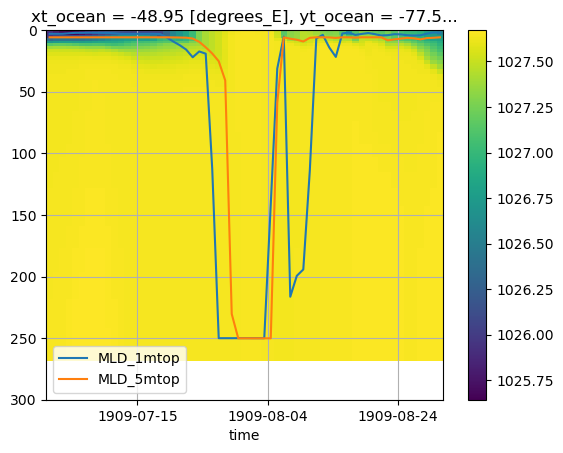

In [24]:
# Wsigma0= (( cc.querying.getvar(expctrl, 'pot_rho_0', gdata_session, start_time='1909-06',end_time='1909-08',\
#                              chunks={'st_ocean':'10gb'},frequency='1 monthly') )\
#                                 * shelf_map_Weddell).weighted(Tarea.fillna(0)).mean(['xt_ocean','yt_ocean']).\
#                                 sel(time='1909-05').mean('time')

Wsigma0= (( cc.querying.getvar(expctrl, 'pot_rho_0', gdata_session, start_time='1909-04',end_time='1909-08',\
                             chunks={'st_ocean':'10gb'},frequency='1 daily') )\
                                * shelf_map_Weddell).\
                                sel(time=slice('1909-07-01','1909-08-30'))
Wsigma0_5m= (( cc.querying.getvar(exp5mtop, 'pot_rho_0', temp_session, start_time='1909-04',end_time='1909-08',\
                             chunks={'st_ocean':'10gb'},frequency='1 daily') )\
                                * shelf_map_Weddell).\
                                sel(time=slice('1909-07-01','1909-08-30'))


Wmld0= (( cc.querying.getvar(expctrl, 'mld', gdata_session, start_time='1909-04',end_time='1909-08'\
                            ,frequency='1 daily') )\
                                * shelf_map_Weddell).\
                                sel(time=slice('1909-07-01','1909-08-30'))
Wmld_5m0= (( cc.querying.getvar(exp5mtop, 'mld', temp_session, start_time='1909-04',end_time='1909-08'\
                            ,frequency='1 daily') )\
                                * shelf_map_Weddell).\
                                sel(time=slice('1909-07-01','1909-08-30'))

Wmld = Wmld0.sel(xt_ocean=-49,yt_ocean=-77.5,method='nearest')
Wmld_5m = Wmld_5m0.sel(xt_ocean=-49,yt_ocean=-77.5,method='nearest')

Wsigma0 = Wsigma0.sel(xt_ocean=-49,yt_ocean=-77.5,method='nearest')

Wsigma0_5m = Wsigma0_5m.sel(xt_ocean=-49,yt_ocean=-77.5,method='nearest')

Wsigma0_5m.plot(x='time',y='st_ocean'); plt.ylim(300,0)
Wmld.plot(x='time',color='tab:blue',label='MLD_1mtop')
Wmld_5m.plot(x='time',color='tab:orange',label='MLD_5mtop')
plt.legend(); plt.grid()

In [25]:
Wmld0.isel(time=slice(0,30)).mean('time').mean().values

array(243.94012, dtype=float32)

In [26]:
Wmld.sel(time='1909-07-31').values,Wmld_5m.sel(time='1909-07-31').values

(array([250.01723], dtype=float32), array([250.1275], dtype=float32))

both models have covection happening at 1909-08-02. lets see this date

(250.0, 0.0)

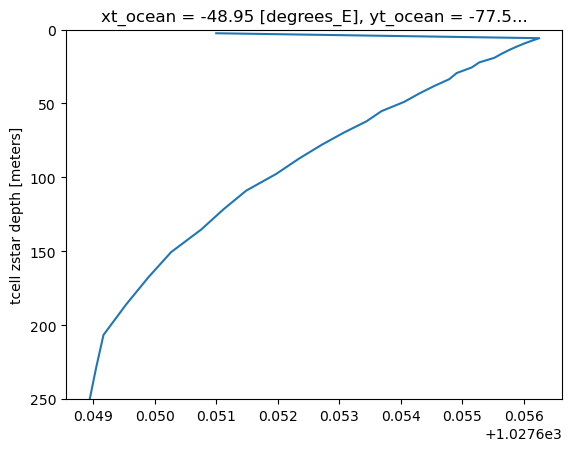

In [27]:
#Wsigma0.sel(time='1909-07-31').plot(y='st_ocean')
Wsigma0_5m.sel(time='1909-07-31').plot(y='st_ocean')
plt.ylim(250,0)

We indeed can find some reversed density profile in a location of Deep convection, on daily timeseries. I guess if the mean is calculated in a prediod where the profile is actively convecting, then the density profile should be reversed? 

### **3.** Labrador sea NADW

In [28]:
def save_SWMT_forcing_NH(expt, session, start_time, end_time, lat_south = 45, n = None):

    ## getvar all required variables
    SST = cc.querying.getvar(expt, 'temp', session, frequency='1 monthly',chunks={'xt_ocean':'100gb','yt_ocean':'100gb'}).isel(st_ocean=0) - 273.15 # SST - conservative temperature in K (sheck this is the case for your run)
    SSS_PSU = cc.querying.getvar(expt, 'salt', session, frequency='1 monthly',chunks={'xt_ocean':'100gb','yt_ocean':'100gb'}).isel(st_ocean=0)      # SSS - practical salinity (not absolute)
    pme_river = cc.querying.getvar(expt, 'pme_river', session, frequency='1 monthly',chunks={'xt_ocean':'100gb','yt_ocean':'100gb'})       # mass flux of precip - evap + river
    # Note that is sfc_salt_flux_ice is not saved, you can use sfc_salt_flux_ice = 0.005 * melt instead
    sfc_salt_flux_ice = cc.querying.getvar(expt, 'sfc_salt_flux_ice', session, frequency='1 monthly',chunks={'xt_ocean':'100gb','yt_ocean':'100gb'})         # mass flux of salt from ice formation/melt
    sfc_salt_flux_restore = cc.querying.getvar(expt, 'sfc_salt_flux_restore', session, frequency='1 monthly',chunks={'xt_ocean':'100gb','yt_ocean':'100gb'}) # mass flux of salt from surface salinity restoring

    ## getvar the components of the net surface heat fux instead of the net_surface_heating variable
    sfc_hflux_from_runoff = cc.querying.getvar(expt, 'sfc_hflux_from_runoff', session, frequency='1 monthly',chunks={'xt_ocean':'100gb','yt_ocean':'100gb'}) # W/m²
    sfc_hflux_coupler = cc.querying.getvar(expt, 'sfc_hflux_coupler', session, frequency='1 monthly',chunks={'xt_ocean':'100gb','yt_ocean':'100gb'})         # W/m²
    sfc_hflux_pme = cc.querying.getvar(expt, 'sfc_hflux_pme', session, frequency='1 monthly',chunks={'xt_ocean':'100gb','yt_ocean':'100gb'})                 # W/m²
    frazil_3d_int_z = cc.querying.getvar(expt, 'frazil_3d_int_z', session, frequency='1 monthly',chunks={'xt_ocean':'100gb','yt_ocean':'100gb'})             # W/m²
    geolon_t = cc.querying.getvar(expt, 'geolon_t', session, n=1)
    geolat_t = cc.querying.getvar(expt, 'geolat_t', session, n=1)
    
    ## slice for time and latitudinal constraints
    time_slice = slice(start_time, end_time)
    lat_slice = slice(lat_south, 90)
    lon_slice=slice(-100,70)
    SST = SST.sel(time=time_slice, yt_ocean=lat_slice,xt_ocean=lon_slice)
    SSS_PSU = SSS_PSU.sel(time=time_slice, yt_ocean=lat_slice,xt_ocean=lon_slice)
    pme_river = pme_river.sel(time=time_slice, yt_ocean=lat_slice,xt_ocean=lon_slice)
    sfc_salt_flux_ice = sfc_salt_flux_ice.sel(time=time_slice, yt_ocean=lat_slice,xt_ocean=lon_slice)
    sfc_salt_flux_restore = sfc_salt_flux_restore.sel(time=time_slice, yt_ocean=lat_slice,xt_ocean=lon_slice)
    sfc_hflux_from_runoff = sfc_hflux_from_runoff.sel(time=time_slice, yt_ocean=lat_slice,xt_ocean=lon_slice)
    sfc_hflux_coupler = sfc_hflux_coupler.sel(time=time_slice, yt_ocean=lat_slice,xt_ocean=lon_slice)
    sfc_hflux_pme = sfc_hflux_pme.sel(time=time_slice, yt_ocean=lat_slice,xt_ocean=lon_slice)
    frazil_3d_int_z = frazil_3d_int_z.sel(time=time_slice, yt_ocean=lat_slice,xt_ocean=lon_slice)
    
    lon_t = geolon_t.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice)
    lat_t = geolat_t.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice)

    ## extract coordinate arrays
    yt_ocean = SST.yt_ocean.values
    xt_ocean = SST.xt_ocean.values
    st_ocean = cc.querying.getvar(expt,'st_ocean',session,n=1).load()
    time_monthly = SST.time.values
    
    ## construct an xarray of days per month (check this is relevant to your run), simple modification if non integer number of years analysed
    start_month = int(start_time[5:7])
    end_month = int(end_time[5:7])
    n_years = int(len(SST.time)/12)
    months_standard_noleap = np.array([31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31])
    if start_month != 1:
        months_offset_noleap = np.append(months_standard_noleap[(start_month-1):],months_standard_noleap[:(start_month-1)])
    else:
        months_offset_noleap = months_standard_noleap

    days_per_month = xr.DataArray(np.tile(months_offset_noleap, n_years), coords = [time_monthly], dims = ['time'], name = 'days per month')

    ## compute net surface heat flux from its component terms
    net_surface_heating = sfc_hflux_from_runoff+ sfc_hflux_coupler+ sfc_hflux_pme+ frazil_3d_int_z # W/m2
    
    ## now I use some TEOS-10 gsw functions to compute absolute salinity, then potential density fields
    ## these are numpy functions, if you have memory errors this is a good step to check (though I have found
    ## this works on the VDI for 0.1 degree data, might be issues for very long time periods)
    depth = -st_ocean[0].values # st_ocean value of the uppermost cell
    depth_tile = (lat_t*0 + 1) * depth
    pressure = xr.DataArray(p_from_z(depth_tile, lat_t), coords = [yt_ocean, xt_ocean], dims = ['yt_ocean', 'xt_ocean'], name = 'pressure', attrs = {'units':'dbar'})
    
    # convert units to absolute salinity 
    SSS = xr.DataArray(SA_from_SP(SSS_PSU, pressure, lon_t, lat_t), coords = [time_monthly, yt_ocean, xt_ocean], dims = ['time','yt_ocean', 'xt_ocean'], name = 'sea surface salinity', attrs = {'units':'Absolute Salinity (g/kg)'})
    





    ## SST is already saved as conservative temperature in this run, if you are working with an older run with potential 
    ## temperature saved, conversion will be required (make sure you work with C not K)
    # SST = xr.DataArray(CT_from_pt(SSS_AS,SST_PT), coords = [time_monthly, yt_ocean, xt_ocean], dims = ['time', 'yt_ocean', 'xt_ocean'], name = 'sea surface temperature', attrs = {'units':'Conservative Temperature (C)'})
    # compute potential density referenced to 1000dbar (or referenced otherwise, depending on your purpose)
    pot_rho_1 = xr.DataArray(sigma0(SSS, SST), coords = [time_monthly, yt_ocean, xt_ocean], dims = ['time', 'yt_ocean', 'xt_ocean'], name = 'potential density ref 1000dbar', attrs = {'units':'kg/m^3 (-1000 kg/m^3)'})
    pot_rho_1 = pot_rho_1.load()
    
    # Compute salt transformation (no density binning)
    haline_contraction = xr.DataArray(beta(SSS, SST, pressure), coords = [time_monthly, yt_ocean, xt_ocean], dims = ['time','yt_ocean', 'xt_ocean'], name = 'saline contraction coefficient (constant conservative temp)', attrs = {'units':'kg/g'})

    # Note that the salt fluxes have units of (kg of salt)/m²/s, while β has
    # units of kg / (g of salt), so we need to multiply the salt fluxes by 1000,
    # the fresh water flux `pme_river` has units of (kg of water)/(m²/s) and needs
    # to be multiplied by SSS to convert to (g of salt)/m²/s
    # This gives units of (kg of water)/m² for the salt_transformation but it
    # will later be divided by time and density and be in m/s:
    salt_transformation = haline_contraction * (SSS * pme_river - (sfc_salt_flux_ice + sfc_salt_flux_restore)*1000) * days_per_month #! before was PSU, why?
    sfc_salt_flux_ice_water=-((sfc_salt_flux_ice/(SSS/1000)) -  sfc_salt_flux_ice)  #sfc_salt_flux_ice in (kg of freshwater)/(m²/s), + freshwater leaves the ocean
    sfc_salt_flux_restore_water = -((sfc_salt_flux_restore/(SSS/1000)) - sfc_salt_flux_restore) # sfc_salt_flux_restore_water in (kg of freshwater)/(m²/s), + freshwater leaves the ocean
    freshwater_fluxes=pme_river + sfc_salt_flux_ice_water + sfc_salt_flux_restore_water

    salt_transformation = salt_transformation.load()






    # Compute heat transformation (no density binning)
    thermal_expansion = xr.DataArray(alpha(SSS, SST, pressure), coords = [time_monthly, yt_ocean, xt_ocean], dims = ['time','yt_ocean', 'xt_ocean'], name = 'thermal expansion coefficient (constant conservative temp)', attrs = {'units':'1/K'})
    heat_transformation = thermal_expansion * net_surface_heating * days_per_month
    heat_transformation = heat_transformation.load()
    
    # Next section does a few things. It cycles through isopycnal bins, determines which cells are 
    # within the given bin for each month, finds the transformation values for those cells for each month, 
    # and sums these through time. You are left with an array of shape (isopyncal bins * lats * lons) 
    # where the array associated with a given isopycnal bin is NaN everywhere except where pot_rho_1 
    # was within the bin, there it has a time summed transformation value.
    
    net_surface_heating.name='net_surface_heating'
    salt_transformation.name='salt_transformation'
    sfc_salt_flux_ice_water.name='sfc_salt_flux_ice_water'
    sfc_salt_flux_restore_water.name='sfc_salt_flux_restore_water'
    heat_transformation.name='heat_transformation'
    freshwater_fluxes.name='salt_flux_into_freshwater_flux'
    data_out = xr.merge([freshwater_fluxes,-heat_transformation,net_surface_heating, sfc_hflux_from_runoff, sfc_hflux_coupler, sfc_hflux_pme, frazil_3d_int_z, thermal_expansion, -salt_transformation, haline_contraction,  pme_river, sfc_salt_flux_ice_water, sfc_salt_flux_restore_water])
    return data_out

Extracting fluxes

In [29]:
start_time="1908-06"
end_time="1909-05"
#getting control fluxes
NActrl_fluxes = save_SWMT_forcing_NH(expctrl, gdata_session, start_time, end_time, lat_south = 45, n = None)
#getting 5mtop fluxes
NAr5mtop_fluxes = save_SWMT_forcing_NH(exp5mtop, temp_session, start_time, end_time, lat_south = 45, n = None)
#getting halfmmtop fluxes
NAhalfmtop_fluxes = save_SWMT_forcing_NH(exphalf, temp_session, start_time, end_time, lat_south = 45, n = None)

We only care about the winter (Notice it is a different period in NA :-]) 

In [30]:
NAwinter_slice=slice("1908-12","1909-01")

NActrl_fluxes = NActrl_fluxes.sel(time=NAwinter_slice).mean('time').compute()
NAr5mtop_fluxes = NAr5mtop_fluxes.sel(time=NAwinter_slice).mean('time').compute()
NAhalfmtop_fluxes = NAhalfmtop_fluxes.sel(time=NAwinter_slice).mean('time').compute()

We only care about what happens in the Labrador Sea, so lets cut out that region

In [31]:
lab_lonslice=slice(-70,-35)
lab_latslice=slice(45,80)

NActrl_fluxes = NActrl_fluxes.sel(xt_ocean=lab_lonslice,yt_ocean=lab_latslice)
NAr5mtop_fluxes = NAr5mtop_fluxes.sel(xt_ocean=lab_lonslice,yt_ocean=lab_latslice)
NAhalfmtop_fluxes = NAhalfmtop_fluxes.sel(xt_ocean=lab_lonslice,yt_ocean=lab_latslice)

We want to use the region with maximum MLD, where deep convection happens in the Labrador sea, for evaluating the fluxes

In [32]:
#Making the NH land masks
NAht = cc.querying.getvar(expctrl, 'ht', gdata_session, n=1) 
NAht = NAht.sel(yt_ocean = slice(45, 80)).compute()
NAland_mask = (NAht*0).fillna(1).compute()
NAht = NAht.sel(xt_ocean=lab_lonslice,yt_ocean=lab_latslice)
NAland_mask= NAland_mask.sel(xt_ocean=lab_lonslice,yt_ocean=lab_latslice)
#getting the MLD during winter to set up the regions

NA_MLDctrl = cc.querying.getvar(expctrl, 'mld', gdata_session, start_time='1908-12',end_time='1909-04',frequency='1 monthly')\
    .sel(xt_ocean=lab_lonslice,yt_ocean=lab_latslice).mean('time') 
NA_MLDctrl.compute()
NA_MLD5mtop = cc.querying.getvar(exp5mtop, 'mld', temp_session, start_time='1908-12',end_time='1909-04',frequency='1 monthly')\
    .sel(xt_ocean=lab_lonslice,yt_ocean=lab_latslice).mean('time') 
NA_MLD5mtop.compute()

/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/xarray/core/dataset.py:282: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/xarray/core/dataset.py:282: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/xarray/core/dataset.py:282: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3

<xarray.DataArray 'mld' (yt_ocean: 713, xt_ocean: 350)>
array([[       nan,        nan,        nan, ..., 175.73775 , 181.90858 ,
        194.3914  ],
       [       nan,        nan,        nan, ..., 181.60303 , 180.91675 ,
        206.11372 ],
       [       nan,        nan,        nan, ..., 180.93678 , 184.59705 ,
        207.5971  ],
       ...,
       [ 12.800114,  12.872696,  12.852099, ...,        nan,        nan,
               nan],
       [ 13.262877,  13.143687,  12.900592, ...,        nan,        nan,
               nan],
       [ 13.916847,  13.084239,  13.390414, ...,        nan,        nan,
               nan]], dtype=float32)
Coordinates:
  * xt_ocean  (xt_ocean) float64 -69.95 -69.85 -69.75 ... -35.25 -35.15 -35.05
  * yt_ocean  (yt_ocean) float64 45.04 45.11 45.18 45.25 ... 79.88 79.93 79.97

Text(0.5, 1.0, '5mtop -  ctrl')

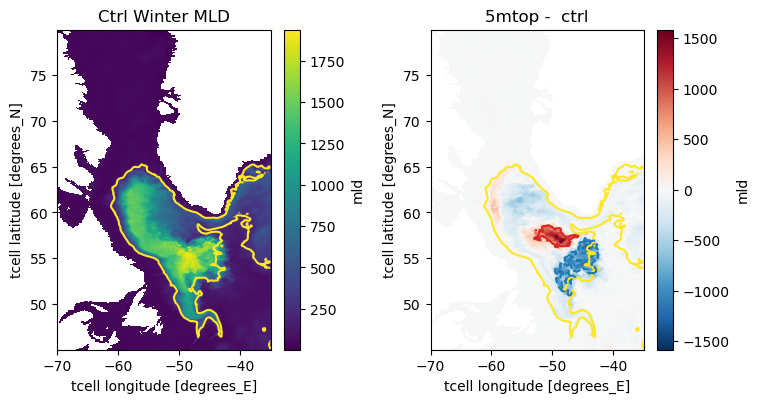

In [33]:
fig  = plt.figure(figsize = (8, 4))
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.45)

convdepth=200
plt.subplot(1,2,1)
NA_MLDctrl.plot()
NA_MLD5mtop.plot.contour(levels=[convdepth])
plt.title('Ctrl Winter MLD')

plt.subplot(1,2,2)
(NA_MLD5mtop - NA_MLDctrl).plot()
NA_MLD5mtop.plot.contour(levels=[convdepth])
(NA_MLD5mtop - NA_MLDctrl).plot.contour(levels=[-700],colors='tab:blue')
(NA_MLD5mtop - NA_MLDctrl).plot.contour(levels=[650],colors='tab:red')
plt.title('5mtop -  ctrl')



creating masks...

Text(0.5, 1.0, 'masks')

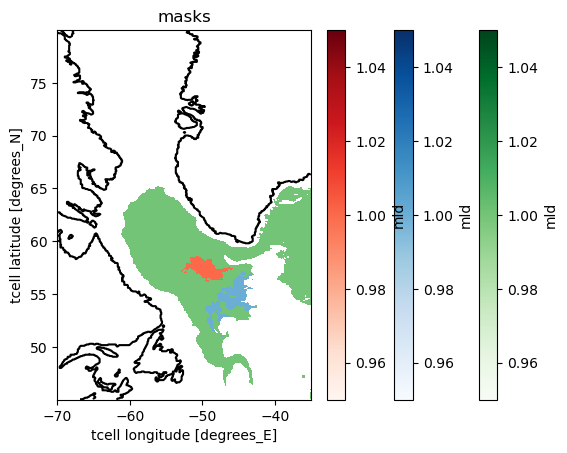

In [34]:
#creating masks

land_mask = (ht*0).fillna(1)
#General mask for location of deep convection
NA_DCmask=(NA_MLD5mtop.where(NA_MLD5mtop>200)*0)+1
#Mask for where the deep convection is decreased
NA_MLDdiff=(NA_MLD5mtop - NA_MLDctrl) * NA_DCmask
NA_NEGmask = (NA_MLDdiff.where(NA_MLDdiff<-700)  * 0 )+1
#Mask for where the deep convection is enhanced
NA_POSmask = (NA_MLDdiff.where(NA_MLDdiff>650)  * 0 )+1

#masks view
NA_DCmask.plot(cmap="Greens")
NA_NEGmask.plot(cmap="Blues")
NA_POSmask.plot(cmap="Reds")
NAland_mask.plot.contour(levels=[0],colors='Black')
plt.title('masks')

In [35]:
#mean depths
(NAht*NA_DCmask*NA_POSmask).mean().values,(NAht*NA_DCmask*NA_NEGmask).mean().values

(array(3562.469, dtype=float32), array(3533.7725, dtype=float32))

In [36]:
#Mean MLD used to limit the depth in the model
(NA_MLDctrl*NA_DCmask*NA_POSmask).mean().values,(NA_MLDctrl*NA_DCmask*NA_NEGmask).mean().values

(array(631.1336, dtype=float32), array(1427.2506, dtype=float32))

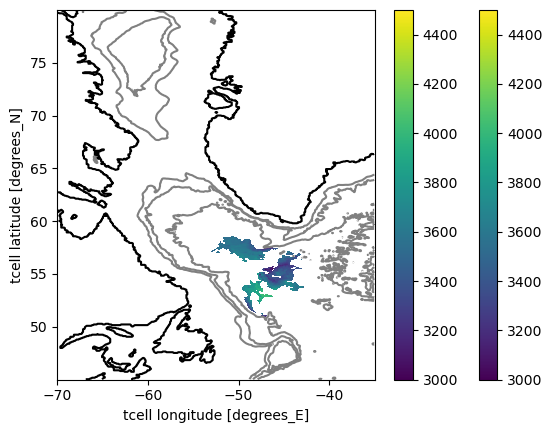

In [37]:
# What is the depth in those places?
(NAht*NA_DCmask*NA_POSmask).plot(vmin=3000,vmax=4500,cmap='viridis')
(NAht*NA_DCmask*NA_NEGmask).plot(vmin=3000,vmax=4500,cmap='viridis')
NAland_mask.plot.contour(levels=[0],colors='Black')
NAht.plot.contour(levels=np.arange(0,4000,1000),colors='grey')

We will constraint the model depth to the maximum MLD. So we can run experiments with 2 depths based on the values above.... $650\ m$ and $1400\ m$ depth

In [38]:
############net surface heating
#ctrl positive region
NAcW_netheatingP = (NActrl_fluxes.net_surface_heating *NA_DCmask*NA_POSmask) #W/m2
NAcW_netheatingP.name="Surface Heat Fluxes [W/m²]"
NAcW_netheatingmeanP = NAcW_netheatingP.weighted(Tarea.fillna(0)).mean(['xt_ocean','yt_ocean']).values
NAcW_netheatingminP = NAcW_netheatingP.min(['xt_ocean','yt_ocean']).values
NAcW_netheatingmaxP = NAcW_netheatingP.max(['xt_ocean','yt_ocean']).values
#ctrl negative region
NAcW_netheatingN = (NActrl_fluxes.net_surface_heating *NA_DCmask*NA_NEGmask) #W/m2
NAcW_netheatingN.name="Surface Heat Fluxes [W/m²]"
NAcW_netheatingmeanN = NAcW_netheatingN.weighted(Tarea.fillna(0)).mean(['xt_ocean','yt_ocean']).values
NAcW_netheatingminN = NAcW_netheatingN.min(['xt_ocean','yt_ocean']).values
NAcW_netheatingmaxN = NAcW_netheatingN.max(['xt_ocean','yt_ocean']).values
NAcW_netheatingtot = (NAcW_netheatingP.fillna(0)+NAcW_netheatingN.fillna(0))
NAcW_netheatingtot=NAcW_netheatingtot.where(NAcW_netheatingtot!=0)


Importing $\tau_x$,$\tau_y$, $T$,$S$

ps: Notice that for the labrador experiments, since the =salt-driven transformation works against the NADW formation, and dont change much, we will just not ise that as forcing to simplify things

In [39]:
#surface area for averaging
NATarea= cc.querying.getvar(expctrl, 'area_t', gdata_session, n=1).sel(xt_ocean=lab_lonslice,yt_ocean=lab_latslice)

#Mean T and S profiles for Weddell
NAJun='1908-06'
NAJul='1908-07'
#Temp and S in the larrge region of deep convection
NAWtemp= ((( cc.querying.getvar(expctrl, 'temp', gdata_session, start_time=NAJun,end_time=NAJul,\
                             chunks={'st_ocean':'10gb'}).sel(time=NAJun) - 273.15 ).
                                sel(xt_ocean=lab_lonslice,yt_ocean=lab_latslice)\
                                 )*NA_DCmask).weighted(NATarea.fillna(0)).mean(['xt_ocean','yt_ocean']).isel(time=0)


NAWsalt= ((( cc.querying.getvar(expctrl, 'salt', gdata_session, start_time=NAJun,end_time=NAJul,\
                             chunks={'st_ocean':'10gb'}).sel(time=NAJun)).
                                sel(xt_ocean=lab_lonslice,yt_ocean=lab_latslice)\
                                 )*NA_DCmask).weighted(NATarea.fillna(0)).mean(['xt_ocean','yt_ocean']).isel(time=0)

NADec='1908-12'
NAJan='1909-01'
#Mean Taux and Tauy and Wind stress
NAW_ucoords= cc.querying.getvar(expctrl, 'tau_x', gdata_session, n=1).sel(xu_ocean=lab_lonslice,yu_ocean=lab_latslice)


NAWTaux= (cc.querying.getvar(expctrl, 'tau_x', gdata_session, start_time=NADec,end_time=NAJan,\
                             chunks={'xu_ocean':'30gb','yu_ocean':'30gb'}).mean('time'))\
                              .sel(xu_ocean=lab_lonslice).sel(yu_ocean=lab_latslice)

NAWTaux
NAWTauxmeanP=(NAWTaux.interp(xu_ocean=NATarea.xt_ocean,yu_ocean=NATarea.yt_ocean)*NA_DCmask*NA_POSmask).weighted(NATarea.fillna(0)).mean(['xt_ocean','yt_ocean'])
NAWTauxmeanN=(NAWTaux.interp(xu_ocean=NATarea.xt_ocean,yu_ocean=NATarea.yt_ocean)*NA_DCmask*NA_NEGmask).weighted(NATarea.fillna(0)).mean(['xt_ocean','yt_ocean'])



NAWTaux.name='Zonal wind stress [N/m²]'


NAWTauy= (cc.querying.getvar(expctrl, 'tau_y', gdata_session, start_time=NADec,end_time=NAJan,\
                             chunks={'xu_ocean':'30gb','yu_ocean':'30gb'}).mean('time'))\
                              .sel(xu_ocean=lab_lonslice).sel(yu_ocean=lab_latslice)
NAWTauy.name='Meridional wind stress [N/m²]'
NAWTauymeanP=(NAWTauy.interp(xu_ocean=NATarea.xt_ocean,yu_ocean=NATarea.yt_ocean)*NA_DCmask*NA_POSmask).weighted(NATarea.fillna(0)).mean(['xt_ocean','yt_ocean'])
NAWTauymeanN=(NAWTauy.interp(xu_ocean=NATarea.xt_ocean,yu_ocean=NATarea.yt_ocean)*NA_DCmask*NA_NEGmask).weighted(NATarea.fillna(0)).mean(['xt_ocean','yt_ocean'])

NAWmeanstress= ((NAWTaux**2) + (NAWTauy**2))**0.5

/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/xarray/core/dataset.py:282: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(


How does the forcing look like on the control?

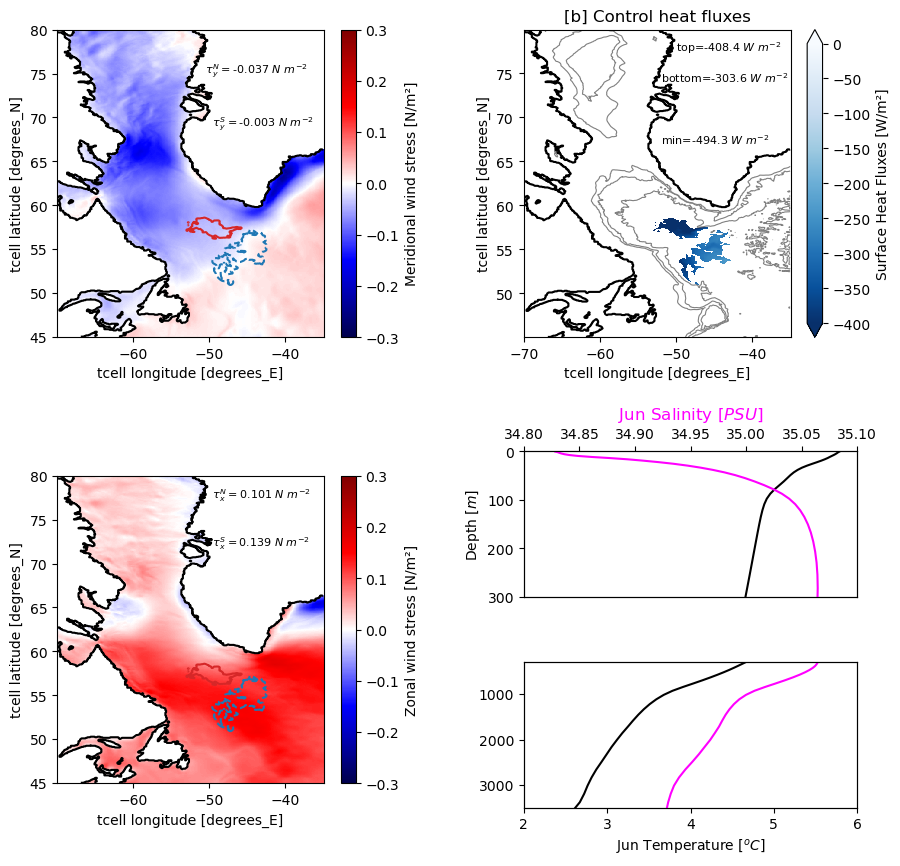

In [40]:
fig  = plt.figure(figsize = (10, 15))
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.45)



# Mean control wind field in winter
ax1 = fig.add_subplot(321)
NAland_mask.plot.contour(levels=[0],colors='Black')
#NAht.plot.contour(levels=np.arange(0,4000,1000),colors='grey',linewidths=0.8)
NAWTauy.plot.pcolormesh(vmin=-.3,vmax=.3,shading='flat',cmap='seismic')
#NATaucont = ax1.contour(NAWTaux.xu_ocean,NAWTaux.yu_ocean,NAWTaux,[-.1,0,.1],colors='grey',linewidths=0.8)
ax1.set_title(r"[a] Winter Wind stress ")
#ax1.clabel(NATaucont, NATaucont.levels, inline=True, fontsize=10)
#ax1.text(-50,77.5,r" $\tau_x^{N} = $" + str(np.round(NAWTauxmeanP.values,3)) + r"$\ N\ m^{-2}$",fontsize=8)
ax1.text(-51,75,r" $\tau_y^{N} = $" + str(np.round(NAWTauymeanP.values,3)) + r"$\ N\ m^{-2}$",fontsize=8)
#ax1.text(-50,72,r" $\tau_x^{S} = $" + str(np.round(NAWTauxmeanN.values,3)) + r"$\ N\ m^{-2}$",fontsize=8)
ax1.text(-50,69,r" $\tau_y^{S} = $" + str(np.round(NAWTauymeanN.values,3)) + r"$\ N\ m^{-2}$",fontsize=8)
(NA_MLD5mtop - NA_MLDctrl).plot.contour(levels=[-700],colors='tab:blue')
(NA_MLD5mtop - NA_MLDctrl).plot.contour(levels=[650],colors='tab:red')



# Mean control wind field in winter
ax3 = fig.add_subplot(323)
NAland_mask.plot.contour(levels=[0],colors='Black')
#NAht.plot.contour(levels=np.arange(0,4000,1000),colors='grey',linewidths=0.8)
NAWTaux.plot(vmin=-.3,vmax=.3,cmap='seismic')
#NATaucont = ax1.contour(NAWTaux.xu_ocean,NAWTaux.yu_ocean,NAWTaux,[-.1,0,.1],colors='grey',linewidths=0.8)
ax3.set_title(r"[a] Winter Wind stress ")
#ax1.clabel(NATaucont, NATaucont.levels, inline=True, fontsize=10)
ax3.text(-50,77.5,r" $\tau_x^{N} = $" + str(np.round(NAWTauxmeanP.values,3)) + r"$\ N\ m^{-2}$",fontsize=8)
#ax1.text(-51,75,r" $\tau_y^{N} = $" + str(np.round(NAWTauymeanP.values,3)) + r"$\ N\ m^{-2}$",fontsize=8)
ax3.text(-50,72,r" $\tau_x^{S} = $" + str(np.round(NAWTauxmeanN.values,3)) + r"$\ N\ m^{-2}$",fontsize=8)
#ax1.text(-50,69,r" $\tau_y^{S} = $" + str(np.round(NAWTauymeanN.values,3)) + r"$\ N\ m^{-2}$",fontsize=8)
(NA_MLD5mtop - NA_MLDctrl).plot.contour(levels=[-700],colors='tab:blue')
(NA_MLD5mtop - NA_MLDctrl).plot.contour(levels=[650],colors='tab:red')


######## Heat Fluxes
ax2 = fig.add_subplot(322)


NAcW_netheatingtot.plot(vmin=-400,vmax=0,cmap='Blues_r',extend='both')
NAland_mask.plot.contour(levels=[0],colors='Black')
NAht.plot.contour(levels=np.arange(0,4000,1000),colors='grey',linewidths=0.8)
ax2.text(-50,77.5,r"top=" + str(np.round(NAcW_netheatingmeanP,1)) + " $W\ m^{-2}$",fontsize=8)
ax2.text(-52,74,r"bottom=" + str(np.round(NAcW_netheatingmeanN,1)) + " $W\ m^{-2}$",fontsize=8)
ax2.text(-52,67,r"min=" + str(np.round(NAcW_netheatingminP,1)) + " $W\ m^{-2}$",fontsize=8)
plt.title('[b] Control heat fluxes')



ax6 = fig.add_subplot(626)
ax6.plot(NAWtemp,NAWtemp.st_ocean,color='black',label='Temp')
ax6.set_xlim([2,6]); ax6.set_ylabel(r"Depth [$m$]");ax6.set_xticks([]); 
ax6_0=ax6.twiny()
ax6_0.plot(NAWsalt,NAWsalt.st_ocean,color='magenta',label='Salt')
ax6_0.set_xlim([34.8,35.1]); 
plt.ylim(300,0)
ax6.set_title(r"Jun Salinity [$PSU$]",color='magenta')


ax8 = fig.add_subplot(628)
ax8.plot(NAWtemp,NAWtemp.st_ocean,color='black',label='Temp')
ax8.set_xlim([2,6]); 
ax8.set_xlabel(r"Jun Temperature [$^oC$]",color='black')
ax8_0=ax8.twiny()
ax8_0.plot(NAWsalt,NAWsalt.st_ocean,color='magenta',label='Salt')
ax8_0.set_xlim([34.8,35.1]); 
plt.ylim(3500,300); ax8_0.set_xticks([]); 


So for the Labrador experiments, we will have a column model with $z_{max}=3500\ m$, and have initial conditions from June, extracted as the mean $T$ and $S$ over the deep convection region defined before. See the profile above for the initial conditions

These labrador experiments will have deep convection forced by heat fluxes. Heat fluxes will be added to the model as sensntive heat flux, and they will range from $-500\ W\ m^{-2}$ to $-200\ W\ m^{-2}$,increasing by $100\ W\ m^{-2}$ at a time. In this case another variant between the two poles above is the wind stress, which is mostly zonal in the bottom blue pole, and have meridional and zonal components in the top red pole. So we would end up with 10 experiments as below:



|**Experiment**| Heat flux |**$\tau_x$ & $\tau_y$** | 
| -- | -- | --|
| N5 | $-500\ W m^{-2}$ | <font color='red'>  North</font> |
| N4 | $-400\ W m^{-2}$ | <font color='red'>  North</font> |
| N3 | $-300\ W m^{-2}$ | <font color='red'>  North</font> |
| N2 | $-200\ W m^{-2}$ | <font color='red'>  North</font>  |
| S5 |$-500\ W m^{-2}$  | <font color='blue'>  South</font> |
| S4 |  $-400\ W m^{-2}$  | <font color='blue'>  South</font> |
| S3 | $-300\ W m^{-2}$ | <font color='blue'>  South</font> |
| S2 | $-200\ W m^{-2}$ | <font color='blue'>  South</font> |


Lets create the IC's for the Labrador experiment then

In [41]:
#Saving ICs
NAWtemp.name='PTemp'
NAWsalt.name='Salinity'
NAWTauxmeanP.name='Tau_x'
NAWTauxmeanN.name='Tau_x'
NAWTauymeanP.name='Tau_y'
NAWTauymeanN.name='Tau_y'
LabP_data = xr.merge([NAWtemp, NAWsalt,NAWTauxmeanP,NAWTauymeanP]) #weak winds case
LabN_data = xr.merge([NAWtemp, NAWsalt,NAWTauxmeanN,NAWTauymeanN]) #strong winds case


#LabN_data.to_netcdf('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/local_input/Lab_IC_N.nc')
#LabP_data.to_netcdf('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/local_input/Lab_IC_S.nc')
